In [1]:
from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

parameters['allow_extrapolation'] = True
WARNING = 30
set_log_level(WARNING)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

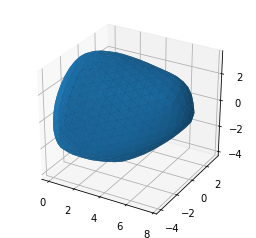

In [2]:
# Importing the mesh
mesh=Mesh()

f = XDMFFile(mesh.mpi_comm(),"Files/pressure_mesh.xdmf")
f.read(mesh)
f.close()

plot(mesh)

In [3]:
# Importing initial pressure

path = "Files/coronary_pressure.csv"

df = pd.read_csv(path,names=['time','pressure'])

In [4]:
time = np.array(df['time'])
pressure = np.array(df['pressure']) # mmHg, 0.133322368 mmHg = 1 Kpa
pressure = pressure * 0.133322368 # KPa

In [5]:
num_time_steps = 100
new_time = np.linspace(0,1,num_time_steps)
func_interpol_p = interp1d(time,pressure)

new_pressure = func_interpol_p(new_time)

time = new_time
pressure = new_pressure

Text(0.5,1,'Initial pressure')

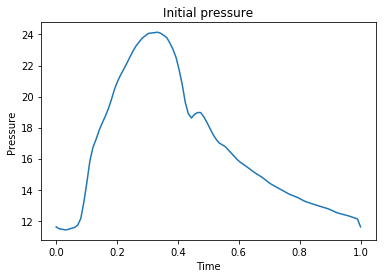

In [6]:
plt.plot(time,pressure)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Initial pressure')

In [7]:
# Define function spaces. Define trial and test functions

el = tetrahedron

P = FiniteElement('P',el,2)


element = MixedElement([P,P,P])
FS = FunctionSpace(mesh,element)


# Define test functions
q1,q2,q3 = TestFunctions(FS)


K1 = Constant(1) #(mm^2)/(kPa*s)
K2 = Constant(10) #(mm^2)/kPa*s
K3 = Constant(20) #(mm^2)/kPa*s
K = Constant((K1,K2,K3))

beta12 = Constant(0.02) #1/(kPa*s)
beta23 = Constant(0.05) #1/(kPa*s)

p = Function(FS)

p1, p2, p3 = split(p)

S3 = - Constant(0.1)*(p3-Constant(3.0)) #Sink term in the third apartment
F = -K1 * dot(grad(p1), grad(q1))*dx + -K2 * dot(grad(p2), grad(q2))*dx + -K3 * dot(grad(p3), grad(q3))*dx \
    + dot(beta12*(p1-p2),q1)*dx + dot(beta12*(p2-p1),q2)*dx + dot(beta23*(p2-p3),q2)*dx + dot(beta23*(p3-p2),q3)*dx\
    + dot(S3,q3)*dx

markers = MeshFunction("size_t",mesh,"Files/pressure_markers.xml")


In [10]:

pD = Expression("p",p=0.0,degree=2)
bc = DirichletBC(FS.sub(0),pD,markers,1)
bcs = [bc]


TOL = 1e-8

vd = Function(FS)
# Set up nonlinear solver
#J = derivative(F, p)
#prob = NonlinearVariationalProblem(F, p, bcs, J=J, form_compiler_parameters={"optimize": True})
#sol = NonlinearVariationalSolver(prob)
#sol.parameters["newton_solver"]["linear_solver"] = "minres"
#sol.parameters["newton_solver"]["preconditioner"] = "jacobi"
#sol.parameters["newton_solver"]["absolute_tolerance"] = TOL
#sol.parameters["newton_solver"]["relative_tolerance"] = TOL

for t,i_p in zip(time,pressure):
    
    print(t)
    
    pD.p = i_p
    
#    sol.solve()
    solve(F==0, p, bc)
    

    
    # Save the pressure
    
    p1,p2,p3 = p.split()
#    xdmffile_p1.write(p1,t)
#    xdmffile_p2.write(p2,t)
#    xdmffile_p3.write(p3,t)
    
    #  Calculate the velosity
    v_d= project(dot(K,grad(p)))
    
    # Save the velocity
    _v_d1,_v_d2,_v_d3 = v_d.split()
    
#    xdmffile_v_d1.write(v_d1,t)
#    xdmffile_v_d2.write(v_d2,t)
#    xdmffile_v_d3.write(v_d3,t)
    

    


    
#xdmffile_p1.close()
#xdmffile_p2.close()
#xdmffile_p3.close()

#xdmffile_v_d1.close()
#xdmffile_v_d2.close()
#xdmffile_v_d3.close()

0.0
0.010101010101010102
0.020202020202020204
0.030303030303030304
0.04040404040404041
0.05050505050505051
0.06060606060606061
0.07070707070707072
0.08080808080808081
0.09090909090909091
0.10101010101010102
0.11111111111111112
0.12121212121212122
0.13131313131313133
0.14141414141414144
0.15151515151515152
0.16161616161616163


KeyboardInterrupt: 